# Information Verifier System

This notebook implements an information verification system using:
- **LangGraph**: Workflow orchestration
- **LangChain**: LLM integration and tools
- **Hugging Face**: Classification models

## Requisites

- Python 3.11
- Pip package manager

## Packages Install

### With pip

In [21]:
%pip install -r requirements.txt -qU

Note: you may need to restart the kernel to use updated packages.


### With UV

In [22]:
%pip install uv

Note: you may need to restart the kernel to use updated packages.


In [23]:
!uv pip install -r requirements.txt

Audited 79 packages in 69ms


## Imports And Keys

In [4]:
import getpass
import os
# OpenAI Version
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [19]:
# Tavily API Key for web search
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

Enter your Tavily API key:  ········


In [24]:
import io
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import TypedDict, Literal, List
from pydantic import BaseModel
from langchain_core.documents import Document
from enum import Enum, auto
from PIL import Image
from langgraph.graph import StateGraph, START, END
from nba_qa_system import NBAQASystem
from tavily import TavilyClient

## Definitions

In [6]:
class ClassificationResult(Enum):
    REAL = auto()
    FAKE = auto()
    DOUBTFUL = auto()

class ClassificationOutput(BaseModel):
    """Structured output for claim classification"""
    classification: Literal["REAL", "FAKE", "DOUBTFUL"]
    explanation: str

class Source(BaseModel):
    url: str
    title: str
    snippet: str
    credibility_score: float = 0.5

class Evidence(BaseModel):
    claim: str
    supporting_text: str
    source: Source
    relevance_score: float

class VerificationState(TypedDict):
    user_input: str
    enhanced_query: str
    search_results: List[Document]
    evidence: List[Evidence]
    classification: ClassificationResult
    confidence: float
    explanation: str
    sources: List[Source]
    valid_query: str

## Models

In [7]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# Initialize QA system with fine-tuned model
qa_system = NBAQASystem(model_name="utils/model_nba_qa_finetuned")

Device set to use mps:0


In [25]:
# Initialize Tavily client for web search
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

## Nodes

In [8]:
def validate_query_node(state: VerificationState) -> VerificationState:
    """Validate user query using NBA QA system's entity analyzer (hybrid approach)"""
    query = state['user_input']
    
    # Step 1: Use QA system's analyzer to extract NBA entities (fast, domain-specific)
    analysis = qa_system.analyzer.analyze(query)
    
    # Check if NBA-related entities were found
    has_players = len(analysis.entities.get('players', [])) > 0
    has_teams = len(analysis.entities.get('teams', [])) > 0
    has_stats = len(analysis.entities.get('stats', [])) > 0
    has_nba_keywords = any(keyword in query.lower() for keyword in [
        'nba', 'finals', 'playoffs', 'championship', 'basketball'
    ])
    
    # If any NBA entity found, it's NBA-related
    if has_players or has_teams or has_stats or has_nba_keywords:
        answer = "YES"
    else:
        # Step 2: Fallback to LLM for ambiguous cases
        # This handles cases like "basketball player" without specific names
        prompt = f"""Is this query about NBA (National Basketball Association) basketball? 
        Answer only YES or NO, nothing else.
        
        Query: {query}"""
        
        try:
            response = model.invoke([HumanMessage(content=prompt)])
            raw_answer = response.content.strip().upper()
            
            # Extract YES or NO from response (handles cases with extra text)
            if "YES" in raw_answer or raw_answer.startswith("Y"):
                answer = "YES"
            elif "NO" in raw_answer or raw_answer.startswith("N"):
                answer = "NO"
            else:
                # Default to NO if unclear
                answer = "NO"
        except Exception as e:
            # If LLM fails, default to NO
            print(f"Warning: LLM validation failed: {e}")
            answer = "NO"
    
    return {
        **state,
        "valid_query": answer
    }

In [9]:
def enhance_query_node(state: VerificationState) -> VerificationState:
    """Enhance user query for better search results"""
    prompt = f"""Given the following user query or claim, create an optimized search query 
    that will help verify the information. Extract key entities, dates, and facts.

    User input: {state['user_input']}
    
    Return only the enhanced search query, nothing else."""
    
    response = model.invoke([HumanMessage(content=prompt)])
    enhanced = response.content.strip()
    
    return {
        **state,
        "enhanced_query": enhanced
    }

In [26]:
def extract_evidence_node(state: VerificationState) -> VerificationState:
    """Extract evidence using both web search and NBA QA system"""
    claim = state['user_input']
    enhanced_query = state['enhanced_query']
    web_results = state.get('search_results', [])

    evidence_list = []
    
    # 1. Process web search results
    for doc in web_results[:3]:  # Top 3 web results
        evidence = Evidence(
            claim=claim,
            supporting_text=doc.page_content[:500],  # Limit snippet length
            source=Source(
                url=doc.metadata.get('url', ''),
                title=doc.metadata.get('title', 'Web Source'),
                snippet=doc.page_content[:200],
                credibility_score=doc.metadata.get('score', 0.7)
            ),
            relevance_score=doc.metadata.get('score', 0.7)
        )
        evidence_list.append(evidence)
    
    # 2. Use QA system for additional evidence
    try:
        qa_result = qa_system.answer(enhanced_query or claim)
        
        if qa_result.answer and qa_result.confidence > 0:
            evidence = Evidence(
                claim=claim,
                supporting_text=qa_result.context_used or qa_result.answer,
                source=Source(
                    url="nba_api:data",
                    title="NBA API Official Data",
                    snippet=qa_result.answer,
                    credibility_score=min(qa_result.confidence, 0.95)
                ),
                relevance_score=qa_result.confidence
            )
            evidence_list.append(evidence)
    except Exception as e:
        print(f"QA system error: {e}")
    
    return {
        **state,
        "evidence": evidence_list,
        "sources": [e.source for e in evidence_list]
    }

In [11]:
def classify_claim_node(state: VerificationState) -> VerificationState:
    """
    Classify the claim as REAL, FAKE, or DOUBTFUL based on evidence using structured output
    """
    
    # Create structured output model
    structured_llm = model.with_structured_output(ClassificationOutput)
    
    prompt = f"""Based on the following evidence, classify the claim as REAL, FAKE, or DOUBTFUL.
    
    Claim: {state['user_input']}
    
    Evidence:
    {chr(10).join([f"- {e.supporting_text} (Source: {e.source.title}, Credibility: {e.source.credibility_score})" for e in state['evidence']])}
    
    Provide your classification (REAL, FAKE, or DOUBTFUL) and a brief explanation."""
    
    # Get structured response
    response = structured_llm.invoke([HumanMessage(content=prompt)])
    
    # Map string classification to enum
    classification_map = {
        "REAL": ClassificationResult.REAL,
        "FAKE": ClassificationResult.FAKE,
        "DOUBTFUL": ClassificationResult.DOUBTFUL
    }
    classification = classification_map.get(response.classification, ClassificationResult.DOUBTFUL)
    
    # Estimate confidence based on evidence credibility
    if state['evidence']:
        avg_credibility = sum(e.source.credibility_score for e in state['evidence']) / len(state['evidence'])
        confidence = avg_credibility
    else:
        confidence = 0.0
    
    return {
        **state,
        "classification": classification,
        "confidence": confidence,
        "explanation": response.explanation
    }

In [12]:
def decline_node(state: VerificationState) -> VerificationState:
    """Decline queries that don't relate to NBA"""
    message = f"Your query does not relate to the NBA theme.\n\nYour input: '{state['user_input']}'\n\nPlease provide a query or claim related to NBA (National Basketball Association) for verification."
    state['explanation'] = message
    return state

In [27]:
def web_search_node(state: VerificationState) -> VerificationState:
    """Search trustworthy NBA sources using Tavily"""
    query = state['enhanced_query'] or state['user_input']
    
    try:
        # Search with domain restrictions for NBA trustworthy sources
        search_results = tavily_client.search(
            query=query + " NBA",
            max_results=5,
            include_domains=["nba.com", "espn.com", "basketball-reference.com", "bleacherreport.com"],
            search_depth="advanced"
        )
        
        # Convert to Document format
        documents = []
        for result in search_results.get('results', []):
            doc = Document(
                page_content=result.get('content', ''),
                metadata={
                    'url': result.get('url', ''),
                    'title': result.get('title', ''),
                    'score': result.get('score', 0.5)
                }
            )
            documents.append(doc)
        
        return {
            **state,
            "search_results": documents
        }
    except Exception as e:
        print(f"Web search error: {e}")
        return {
            **state,
            "search_results": []
        }

## Conditional Nodes

In [13]:
def decide_over_input_node(state: VerificationState) -> Literal["enhance_query", "decline"]:
    if state["valid_query"] == "YES":
        return "enhance_query"
    else:
        return "decline"

## Workflow

In [28]:
builder = StateGraph(VerificationState)

builder.add_node("enhance_query", enhance_query_node)
builder.add_node("validate_query", validate_query_node)
builder.add_node("decline", decline_node)
builder.add_node("web_search", web_search_node)  # NEW
builder.add_node("extract_evidence", extract_evidence_node)
builder.add_node("classify_claim", classify_claim_node)

builder.add_edge(START, "validate_query")
builder.add_conditional_edges("validate_query", decide_over_input_node)
builder.add_edge("decline", END)
builder.add_edge("enhance_query", "web_search")  # NEW
builder.add_edge("web_search", "extract_evidence")  # NEW
builder.add_edge("extract_evidence", "classify_claim")
builder.add_edge("classify_claim", END)
graph = builder.compile()

### Workflow Image

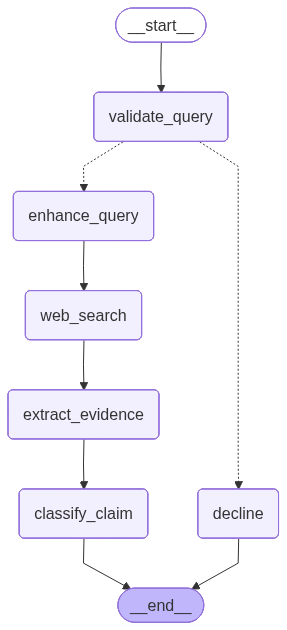

In [29]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [33]:
user_input = "Kobe Bryant scored 20 points in the 2010 NBA Finals Game 7"
#user_input = "LeBron James was a golf player?" # Should be declined
#user_input = "The capital of France is Paris." # Should be declined

In [34]:
# Example usage
config = {"configurable": {"thread_id": "1"}}

initial_state = VerificationState(
    user_input=user_input,
    enhanced_query="",
    search_results=[],
    evidence=[],
    classification=ClassificationResult.DOUBTFUL,
    confidence=0.0,
    explanation="",
    sources=[],
    valid_query=""
)

result = graph.invoke(initial_state, config)

In [35]:
# Display the results
print("=" * 60)
print("VERIFICATION RESULT")
print("=" * 60)
print(f"\nClaim: {result['user_input']}")
print(f"\nValid Query: {result['valid_query']}")
print(f"\nEnhanced Query: {result['enhanced_query']}")
print(f"\nExplanation: {result['explanation']}")
print(f"\nClassification: {result['classification'].name}")
print("\nEvidence Sources:")
for source in result['sources']:
    print(f"- {source.title} ({source.url}) - Credibility: {source.credibility_score:.2f}")

VERIFICATION RESULT

Claim: Kobe Bryant scored 20 points in the 2010 NBA Finals Game 7

Valid Query: YES

Enhanced Query: "Kobe Bryant 2010 NBA Finals Game 7 points scored"

Explanation: The evidence shows that Kobe Bryant scored 23 points in the 2010 NBA Finals Game 7, not 20. The box score stats from a credible source (Credibility: 0.9310187) list Kobe Bryant's points as 23.

Classification: FAKE

Evidence Sources:
- 2010 NBA Finals Game 7: Celtics vs Lakers, June 17, 2010 (https://www.basketball-reference.com/boxscores/201006170LAL.html) - Credibility: 0.93
- All-Time NBA Finals Game 7s (https://www.nba.com/news/all-time-nba-finals-game-7s) - Credibility: 0.86
- NBA Finals 2010 (https://www.nba.com/watch/list/collection/nba-finals-2010) - Credibility: 0.84
- NBA API Official Data (nba_api:data) - Credibility: 0.00
